# Imports

In [1]:
import git
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import geopandas as gp
from geopy.distance import geodesic
import ipywidgets as widgets
from itables import init_notebook_mode


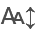

In [15]:
init_notebook_mode(all_interactive=True)

https://geopandas.org/en/stable/getting_started.html

# Update

In [3]:
print(git.Repo().submodule_update(init=True).module().git.pull())
print(git.Repo().submodule_update(init=True).module().git.status())

Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Airports.ipynb
	modified:   ourairports-data (new commits)

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.DS_Store
	Draft.ipynb
	requirements.txt

no changes added to commit (use "git add" and/or "git commit -a")


# Load data

In [4]:
airports = pd.read_csv("ourairports-data/airports.csv", index_col="id")
runways = pd.read_csv("ourairports-data/runways.csv", index_col="id")
freqs = pd.read_csv("ourairports-data/airport-frequencies.csv", index_col="id")
countries = pd.read_csv("ourairports-data/countries.csv", index_col="id")
regions = pd.read_csv("ourairports-data/regions.csv", index_col="id")

# Search by distance

In [5]:
icao_codes = tuple(airports["ident"].unique())
icao_selector = widgets.Combobox(
    options=icao_codes,
    value="EGCC",
    description="ICAO codes",
    disabled=False,
)
display(icao_selector)

Combobox(value='EGCC', description='ICAO codes', options=('00A', '00AA', '00AK', '00AL', '00AN', '00AS', '00AZ…

In [6]:
min_distance_selector = widgets.FloatLogSlider(
    value=100,
    description="Minimum distance",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
)
display(min_distance_selector)

FloatLogSlider(value=100.0, continuous_update=False, description='Minimum distance', readout_format='.1f')

In [7]:
max_distance_selector = widgets.FloatLogSlider(
    value=200,
    description="Maximum distance",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
)
display(max_distance_selector)

FloatLogSlider(value=200.0, continuous_update=False, description='Maximum distance', readout_format='.1f')

In [8]:
# Create a global button
update_button = widgets.Button(
    description="Update Data",
    button_style="primary",  # Blue button
    tooltip="Click to refresh all data",
    icon="refresh",
)

# Display the button
display(update_button)

Button(button_style='primary', description='Update Data', icon='refresh', style=ButtonStyle(), tooltip='Click …

In [9]:
# Output widgets for each function
freqs_output = widgets.Output()
runways_output = widgets.Output()
shortest_distances_output = widgets.Output()
range_distances_output = widgets.Output()

In [10]:
def update_all(_):
    global airports
    ident = icao_selector.value  # Use selected ICAO
    airport = airports.loc[airports["ident"] == ident]
    airports["Distance"] = airports.apply(
        lambda row: geodesic(
            (airport["latitude_deg"].values[0], airport["longitude_deg"].values[0]),
            (row["latitude_deg"], row["longitude_deg"]),
        ).nm,
        axis=1,
    ).round(1)
    airports = airports.sort_values("Distance")
    with freqs_output:
        freqs_output.clear_output(wait=True)
        display(freqs[freqs["airport_ident"] == ident])

    with runways_output:
        runways_output.clear_output(wait=True)
        display(runways[runways["airport_ident"] == ident])

    with shortest_distances_output:
        shortest_distances_output.clear_output(wait=True)
        display(airports.head(10))  # Show nearest 10

    with range_distances_output:
        range_distances_output.clear_output(wait=True)
        display(
            airports[
                (airports["Distance"] >= min_distance_selector.value)
                & (airports["Distance"] <= max_distance_selector.value)
            ]
        )


# Attach the function to the button
update_button.on_click(update_all)

In [11]:
display(freqs_output)

Output()

In [12]:
display(runways_output)

Output()

In [13]:
display(shortest_distances_output)

Output()

In [14]:
display(range_distances_output)

Output()

# Airports by country

In [53]:
airports.groupby("iso_country").nunique()

ident  type  name  latitude_deg  longitude_deg  elevation_ft  \
iso_country                                                                 
AD               3     2     3             3              3             1   
AE             255     6   250           253            254            69   
AF              79     4    79            79             79            66   
AG               6     3     6             6              6             4   
AI               2     2     2             2              2             1   
...            ...   ...   ...           ...            ...           ...   
YE              44     4    44            44             44            31   
YT               1     1     1             1              1             1   
ZA             652     6   651           647            651           495   
ZM             126     5   126           126            126            89   
ZW             155     5   155           155            154           109   

             continent  iso_region  municipality  scheduled_service  \
iso_country                                                           
AD                   1           2             2                  1   
AE                   1           8            84                  2   
AF                   1          29            64                  2   
AG                   0           4             5                  2   
AI                   0           1             2                  2   
...                ...         ...           ...                ...   
YE                   1          16            32                  2   
YT                   1           1             1                  1   
ZA                   1          10           499                  2   
ZM                   1          11           106                  2   
ZW                   1          10           110                  2   

             icao_code  iata_code  gps_code  local_code  home_link  \
iso_country                                                          
AD                   0          0         0           0          0   
AE                  12         15        27           2         10   
AF                  33         33        45           1          2   
AG                   2          2         4           0          0   
AI                   1          1         1           0          1   
...                ...        ...       ...         ...        ...   
YE                  15         22        23           3          0   
YT                   1          1         1           0          0   
ZA                  78         92       320           8         30   
ZM                  17         24        82           0          3   
ZW                  10         13        93           2          2   

             wikipedia_link  keywords  Distance  
iso_country                                      
AD                        1         0         3  
AE                       26        12       190  
AF                       37        35        76  
AG                        3         2         6  
AI                        1         1         2  
...                     ...       ...       ...  
YE                       19        11        43  
YT                        1         0         1  
ZA                       67        62       604  
ZM                       25         9       125  
ZW                       21        16       149  

[244 rows x 18 columns]

# Airports by elevation

<Axes: ylabel='Frequency'>

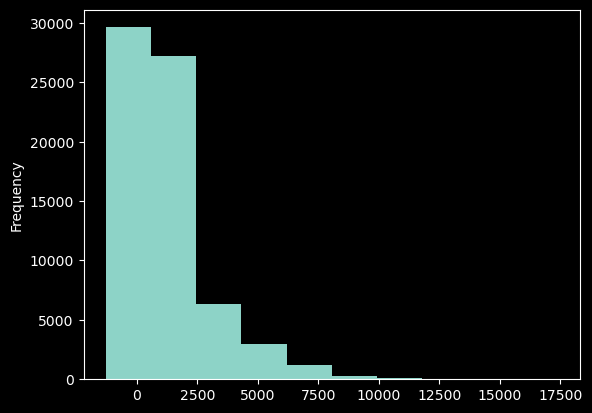

In [55]:
airports["elevation_ft"].plot.hist()

# Airports by ISO region

In [52]:
airports.groupby("iso_region").nunique()

ident  type  name  latitude_deg  longitude_deg  elevation_ft  \
iso_region                                                                 
AD-04           2     2     2             2              2             0   
AD-08           1     1     1             1              1             1   
AE-AJ          10     1    10            10             10             6   
AE-AZ         150     6   147           150            150            41   
AE-DU          24     5    22            23             23            10   
...           ...   ...   ...           ...            ...           ...   
ZW-MI          18     3    18            18             18            12   
ZW-MN          34     4    34            34             34            28   
ZW-MS          12     1    12            12             12             8   
ZW-MV          17     2    17            17             17            10   
ZW-MW          33     3    33            33             33            26   

            continent  iso_country  municipality  scheduled_service  \
iso_region                                                            
AD-04               1            1             1                  1   
AD-08               1            1             1                  1   
AE-AJ               1            1             3                  1   
AE-AZ               1            1            53                  2   
AE-DU               1            1             8                  2   
...               ...          ...           ...                ...   
ZW-MI               1            1            12                  1   
ZW-MN               1            1            21                  2   
ZW-MS               1            1            12                  1   
ZW-MV               1            1            12                  1   
ZW-MW               1            1            23                  1   

            icao_code  iata_code  gps_code  local_code  home_link  \
iso_region                                                          
AD-04               0          0         0           0          0   
AD-08               0          0         0           0          0   
AE-AJ               0          0         0           0          0   
AE-AZ               6          7        18           1          4   
AE-DU               3          5         3           0          5   
...               ...        ...       ...         ...        ...   
ZW-MI               1          1        12           1          0   
ZW-MN               3          3        14           0          0   
ZW-MS               0          0         7           0          0   
ZW-MV               2          2        10           1          1   
ZW-MW               1          2        23           0          1   

            wikipedia_link  keywords  Distance  
iso_region                                      
AD-04                    0         0         2  
AD-08                    1         0         1  
AE-AJ                    0         0         7  
AE-AZ                   16         7       129  
AE-DU                    4         3        19  
...                    ...       ...       ...  
ZW-MI                    3         1        18  
ZW-MN                    3         3        33  
ZW-MS                    0         0        12  
ZW-MV                    2         1        17  
ZW-MW                    2         5        30  

[2944 rows x 18 columns]

# Scheduled service

In [51]:
airports.groupby("scheduled_service").nunique()

ident  type   name  latitude_deg  longitude_deg  \
scheduled_service                                                    
no                 77915     7  73586         76877          77127   
yes                 4412     6   4400          4411           4410   

                   elevation_ft  continent  iso_country  iso_region  \
scheduled_service                                                     
no                         6243          6          228        2701   
yes                        1727          6          235        1676   

                   municipality  icao_code  iata_code  gps_code  local_code  \
scheduled_service                                                             
no                        34294       3873       4939     38822       32184   
yes                        4153       3751       4159      4268        1201   

                   home_link  wikipedia_link  keywords  Distance  
scheduled_service                                                 
no                      3059           12116     17767     38177  
yes                     1151            4255      1591      4257

# Maps

In [48]:
world = gp.read_file("ne_10m_admin_0_countries.geojson")
# world.plot()

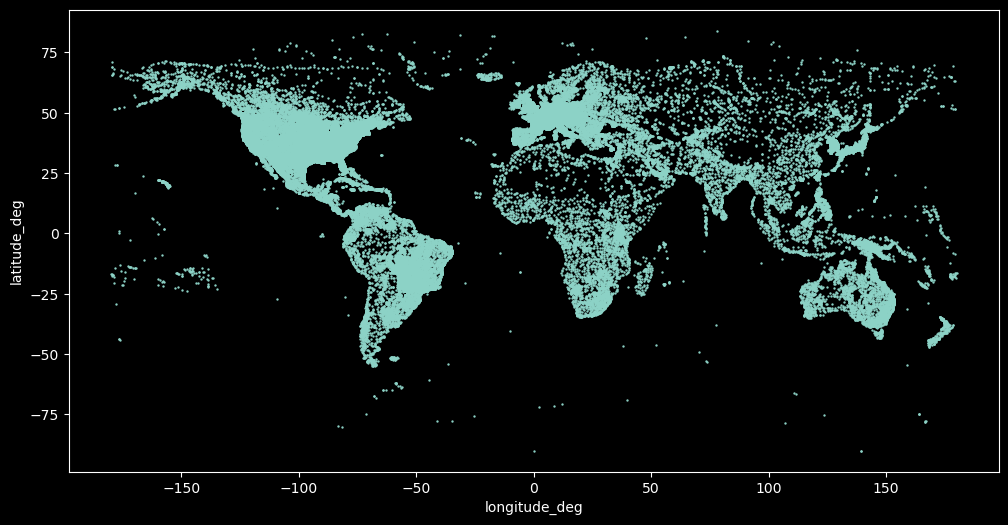

In [49]:
airports.plot.scatter(y="latitude_deg", x="longitude_deg", s=0.5, figsize=(12, 6))
plt.show()

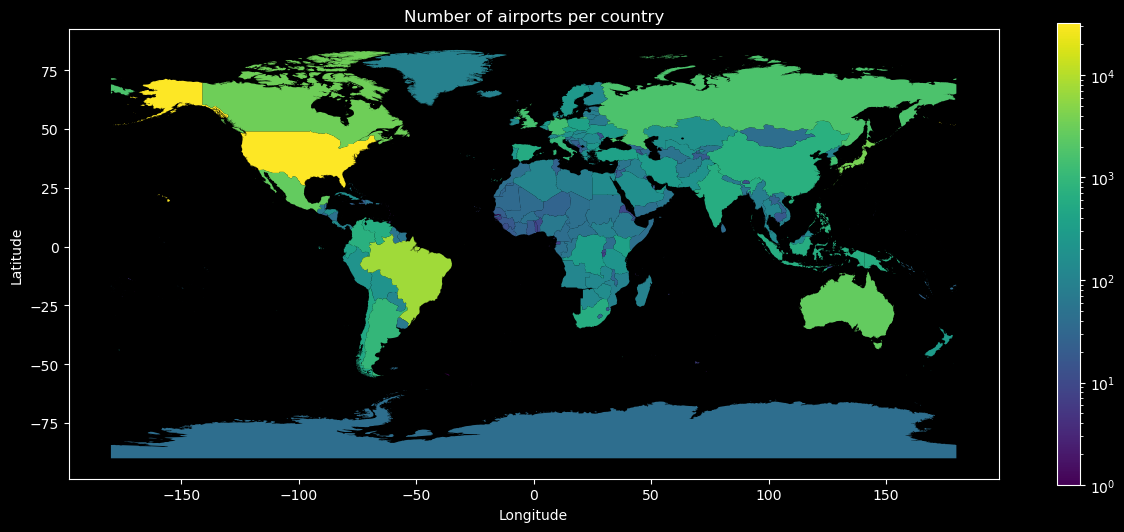

In [50]:
temp = airports.groupby("iso_country")["ident"].nunique()
world.merge(temp, right_index=True, left_on="ISO_A2", how="left").plot(
    "ident", legend=True, norm=LogNorm(), figsize=(15, 6)
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Number of airports per country")
plt.show()